This notebook applies Doc2Vec and Scoring fucntion on the consumer reviews to quantify product-level differences.

In [98]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## Data

Check out [this notebook](https://github.com/liu431/Content-Analysis-Project/blob/master/Data/data_extraction_electronics.ipynb) for getting the Amazon Review Data (2018), transformed the format, and extracted the sample corpus.


Sample data: metadata and reviews of 10 keyboards that have highest reviews in the data 

In [99]:
df = pd.read_csv("https://raw.githubusercontent.com/liu431/Content-Analysis-Project/master/Data/output_review.csv")
df_meta = pd.read_csv("https://raw.githubusercontent.com/liu431/Content-Analysis-Project/master/Data/output_meta.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
tbl = df.groupby('asin').agg({'overall':'count'})
tbl = tbl.sort_values(by = ['overall'], ascending = False)
tbl['asin'] = tbl.index
tbl = tbl.rename_axis("ID")

In [101]:
# downsampling
df_sample = df[df['asin'] == tbl.index[-1]]
for i in range(4):
    df_temp = df[df['asin'] == tbl.index[i]].sample(n=350)
    df_sample = df_sample.append(df_temp)

In [102]:
df_sample = df_sample[df_sample['reviewText'].notnull()]
df_agg = df.groupby(['asin', 'title'], as_index=False)[['reviewText']].agg(sum)
df_agg['Brand'] = ['Microsoft', 'HP', 'Azio', 'Redragon', 'Jelly']
df_agg

,asin,title,reviewText,Brand
0,B000A6PPOK,Microsoft Natural Ergonomic Keyboard 4000,"As a software developer, I am literally attach...",Microsoft
1,B00E4TOWR0,HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),Love it. The keys are placed where I like the...,HP
2,B00I0S6SK0,Azio Vision Backlit USB Keyboard with Large Pr...,This is just what I needed and it works great....,Azio
3,B00LSGKEC4,Redragon K502 Gaming Keyboard RGB LED Backlit ...,"This would have been five stars, but I receive...",Redragon
4,B0194MC7JG,Wireless Keyboard and Mouse - Jelly Comb K025 ...,I didn't think it would be possible with this ...,Jelly


## Doc2Vec

### Cleaning

In [103]:
df_agg['tokenized_words'] = df_agg['reviewText'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_agg['normalized_words'] = df_agg['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [104]:
keywords = ['Microsoft', 'HP', 'Azio', 'Redragon', 'Jelly']

In [105]:
taggedDocs = []
for index, row in df_agg.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['asin'])
    docKeywords.append(row['Brand']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
df_agg['TaggedReviews'] = taggedDocs

In [106]:
docKeywords

['B0194MC7JG', 'Jelly']

### Model

In [107]:
dfD2V = gensim.models.doc2vec.Doc2Vec(df_agg['TaggedReviews'], vector_size = 100) #Limiting to 100 dimensions

### Analysis

In [108]:
dfD2V.most_similar(positive = ['feel','great'], negative = ['like'], topn = 1)

[('keys', 0.9998048543930054)]

#### Words that are most similar to the whole document

In [109]:
dfD2V.most_similar( [ dfD2V.docvecs['B000A6PPOK'] ], topn=5) 

[('natural', 0.9969996809959412),
 ('ergo', 0.9951712489128113),
 ('tunnel', 0.994288980960846),
 ('fatigue', 0.9931846261024475),
 ('pain', 0.9925909638404846)]

#### Recommend products by keywords

In [110]:
dfD2V.docvecs.most_similar([dfD2V['wireless']], topn=5 )

[('B0194MC7JG', 0.9998785257339478),
 ('Jelly', 0.999872624874115),
 ('B00E4TOWR0', 0.9922264218330383),
 ('HP', 0.9922038912773132),
 ('Redragon', 0.9858355522155762)]

In [111]:
dfD2V.docvecs.most_similar([ dfD2V['wireless']+dfD2V['keyboard']], topn=5 )

[('B0194MC7JG', 0.9982744455337524),
 ('Jelly', 0.9982694387435913),
 ('B00E4TOWR0', 0.9981154203414917),
 ('HP', 0.9981027841567993),
 ('Redragon', 0.9944585561752319)]

#### Heatmap: cosine similarities between products

In [112]:
targetDocs = df_agg['Brand']

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = dfD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, dfD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

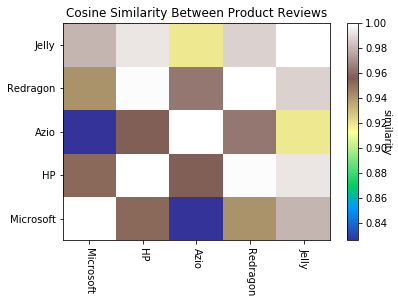

In [126]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

plt.title('Cosine Similarity Between Product Reviews')
cbar.set_label('similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

plt.savefig('Plots/CosineSimilarity.png')

####  Doc2Vec Distance

In [114]:
#B000A6PPOK as baseline
distance = pd.DataFrame({'Product':df_agg['Brand'], 'similarities':heatmapMatrixD[0]})
distance['diff'] = distance['similarities']-1
distance.round(2)

<IPython.core.display.Javascript object>

,Product,similarities,diff
0,Microsoft,1.00,0.00
1,HP,0.95,-0.05
2,Azio,0.83,-0.17
3,Redragon,0.94,-0.06
4,Jelly,0.98,-0.02


## Scoring function

Calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors.

In [115]:
df_meta['tokenized_words'] = df_meta['feature'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_meta['normalized_words'] = df_meta['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))
df_meta

,Unnamed: 0,overall,asin,category,description,title,image,brand,feature,rank,...,price,also_buy,also_view,similar_item,tech1,tech2,details,fit,tokenized_words,normalized_words
0,92,2567,B000A6PPOK,"['Electronics', 'Computers & Accessories', 'Co...",['USB'],Microsoft Natural Ergonomic Keyboard 4000,['https://images-na.ssl-images-amazon.com/imag...,Microsoft,['Split ergonomic design encourages natural ha...,['>#222 in Computers & Accessories > Computer ...,...,$48.50,"['B00FPAVUHC', 'B0043T7FXE', 'B001F42MKG', 'B0...","['B075GZVD4T', 'B002MMY4WY', 'B00CYX26BC', 'B0...","[{'asin': '', 'href': '', 'name': 'Microsoft N...",NaN,NaN,NaN,NaN,"[Split, ergonomic, design, encourages, natural...","[split, ergonomic, design, encourages, natural..."
1,191,1805,B00I0S6SK0,"['Electronics', 'Computers & Accessories', 'Co...",['The AZiO Vision keyboard features extra larg...,Azio Vision Backlit USB Keyboard with Large Pr...,['https://images-na.ssl-images-amazon.com/imag...,Azio,['Easy to see large print keys. 2x Larger than...,['>#56 in Computers & Accessories > Computer A...,...,$2.54,"['B00ERV026K', 'B0787QZ6WD', 'B075WW7V6W', 'B0...","['B003VAGXWK', 'B00AGI7NKG', 'B007ZUC7DG', 'B0...","[{'asin': '', 'href': '', 'name': 'Azio Vision...",{'Number of USB 2.0 Ports': '1'},"{'Brand Name': 'Azio', 'Item model number': 'K...",NaN,NaN,"[Easy, to, see, large, print, keys, 2x, Larger...","[easy, large, print, keys, 2x, larger, convent..."
2,2263,418,B00E4TOWR0,"['Electronics', 'Computers & Accessories', 'Co...","[""Get-more-done productivity: Achieve more wit...",HP Wired USB Keyboard K1500 (Black) (H3C52AA#ABA),['https://images-na.ssl-images-amazon.com/imag...,HP,['Get-more-done productivity: Achieve more wit...,['>#25 in Computers & Accessories > Computer A...,...,$14.99,NaN,"['B005EOWBHC', 'B00ZYLMQH0', 'B004YDSPSS', 'B0...","[{'asin': '', 'href': '', 'name': 'HP Wired US...","{'Brand Name': 'HP', 'Series': 'H3C52AA', 'Ite...",NaN,NaN,NaN,"[Get, more, done, productivity, Achieve, more,...","[productivity, achieve, hp, keyboard, k1500, i..."
3,2620,378,B00LSGKEC4,"['Electronics', 'Computers & Accessories', 'Co...",NaN,Redragon K502 Gaming Keyboard RGB LED Backlit ...,['https://images-na.ssl-images-amazon.com/imag...,Redragon,['SILENT GAMING KEYBOARD; 104 Key Gaming Keybo...,>#263 in Computers & Accessories > Computer Ac...,...,$28.99,"['B00HTK1NCS', 'B011HMDZ0Q', 'B00GU4F4OM', 'B0...","['B073DBS35C', 'B074DRFHYS', 'B01EOH2JLW', 'B0...","[{'asin': '', 'href': '', 'name': 'Redragon K5...","{'Brand Name': 'Redragon', 'Series': 'K502 Kar...",NaN,NaN,NaN,"[SILENT, GAMING, KEYBOARD, 104, Key, Gaming, K...","[silent, gaming, keyboard, key, gaming, keyboa..."
4,2962,343,B0194MC7JG,"['Electronics', 'Computers & Accessories', 'Co...",['ONE WIRELESS KEYBOARD AND MOUSE SET FOR WIRE...,Wireless Keyboard and Mouse - Jelly Comb K025 ...,['https://images-na.ssl-images-amazon.com/imag...,Jelly Comb,['RELIABLE 2.4GHz WIRELESS CONNECTION: 10m or ...,['>#323 in Computers & Accessories > Computer ...,...,$2.54,"['B01B4RWTAG', 'B001CJRM36', 'B0181JTPCU', 'B0...",NaN,"[{'asin': '', 'href': '', 'name': 'Wireless Ke...",NaN,NaN,NaN,NaN,"[RELIABLE, 2.4GHz, WIRELESS, CONNECTION, 10, m...","[reliable, 2.4ghz, wireless, connection, m, fe..."


In [116]:
def adprob(ad, model):
    '''a function to calculate the likelihood of each product description. '''
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [117]:
self_likelihood = []
for i in range(len(df_meta['asin'])):
    W2V = gensim.models.word2vec.Word2Vec(df_agg['normalized_words'].iloc[i], hs=1, negative=0)
    vocab = W2V.wv.index2word
    self_likelihood.append(adprob(df_meta['normalized_words'].iloc[i], W2V))

In [118]:
df_meta['self_likelihood'] = self_likelihood

In [119]:
self_likelihood

[-18.527168, -18.031813, -19.199415, -20.649729, -20.083733]

In [120]:
np.argmin(self_likelihood)

3

In [121]:
meta['title'][np.argmin(self_likelihood)]

'Redragon K502 Gaming Keyboard RGB LED Backlit Illuminated 104 Key Silent Keyboard Karura with Wrist Rest for Windows PC Games (New Improved Version)'

In [122]:
meta['title'][np.argmax(self_likelihood)]

'Azio Vision Backlit USB Keyboard with Large Print keys and 5 Interchangeable Backlight Colors (KB506) - Wired'

In [123]:
#B000A6PPOK as baseline
likelihood = pd.DataFrame({'Product':df_agg['Brand'], 'Likelihood':self_likelihood})
likelihood['Trustworthiness'] = -(likelihood['Likelihood']- likelihood['Likelihood'][0])/likelihood['Likelihood'][0]
likelihood.round(2)

<IPython.core.display.Javascript object>

,Product,Likelihood,Trustworthiness
0,Microsoft,-18.53,0.00
1,HP,-18.03,0.03
2,Azio,-19.20,-0.04
3,Redragon,-20.65,-0.11
4,Jelly,-20.08,-0.08


In [136]:
likelihood_sort = likelihood.sort_values(by=['Trustworthiness'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

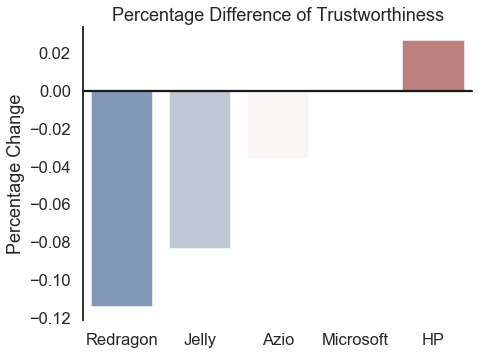

In [157]:
sns.set(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, ax1 = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

x = np.array(likelihood_sort['Product'])
y1 = likelihood_sort['Trustworthiness']

# Center the data to make it diverging
sns.barplot(x=x, y=y1, palette="vlag", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Percentage Change")

# Finalize the plot
sns.despine(bottom=True)
#plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)
plt.title('Percentage Difference of Trustworthiness')
plt.savefig('Plots/Percentage Difference of Trustworthiness.png')